# Fetal immune Visium ST data - exploration 

In this notebook we load and visualize spatial transcriptomics data from human developing organs. See [our preprint] for more information on how this data was generated.

In [29]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

Define some utility functions for plotting

In [33]:
# pip install matplotlib-scalebar
from matplotlib_scalebar.scalebar import ScaleBar

def get_pixel_size_visium(adata, library_id, spot_diameter_real = 55, img='lowres'):
    '''
    Utility function to get size of pixels from visium image in AnnData.
    Useful to plot scalebars with matplotlib_scalebar.ScaleBar
    
    Params:
    -------
    - adata: AnnData object storing image info in adata.uns[spatial]
    - library_id: string storing ID for image, must be a key in adata.uns[spatial]
    - spot_diameter_real: numeric storing real diameter of spot, in whatever unit you need 
        (default is 55, for 55 microns of Visium 10X spots)
    - img: which image to use (default: lowres)
    '''

    ## get scale factor converting original pixel positions (adata.obsm['spatial']) to 
    # pixel positions in image
    scalef = adata.uns['spatial'][library_id]['scalefactors']['tissue_{i}_scalef'.format(i=img)]
    ## get spot diameter in image pixels
    spot_diameter_img = adata.uns['spatial'][library_id]['scalefactors']['spot_diameter_fullres'] * scalef
    ## Calculate pixel size
    pixel_size_real = spot_diameter_real/spot_diameter_img
    return(pixel_size_real)

def _select_lib_spots(adata, l):
    select_spots = adata.obs['Data_dir_name'] == l
    return(adata[select_spots])

# def _spatial_plot_lib(adata_vis, lib, color_by=None, **kwargs):
#     with matplotlib.rc_context({"axes.facecolor": "black"}):
#         s_ind = adata_vis.obs['Data_dir_name'] == lib
#         s_keys = list(adata_vis.uns['spatial'].keys())
#         s_spatial = np.array(s_keys)[[lib in i for i in s_keys]][0]
#         adata_small = adata_vis[s_ind, :].copy()
#         sc.pl.spatial(adata_small, library_id=s_spatial,
#                                 **kwargs)

# def select_slide(adata, s, s_col='sample'):
#     r""" This function selects the data for one slide from the spatial anndata object.
    
#     :param adata: Anndata object with multiple spatial experiments
#     :param s: name of selected experiment
#     :param s_col: column in adata.obs listing experiment name for each location
#     """
    
#     slide = adata[adata.obs[s_col].isin([s]), :].copy()
#     s_keys = list(slide.uns['spatial'].keys())
#     s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

#     slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
    
#     return slide

# def plot_spatial_per_cell_type(adata, 
#                                    cell_type='total_counts',
#                                    samples=['WSSS_F_IMMsp9838712', 'WSSS_F_IMMsp9838717', 
#                                              'WSSS_F_IMMsp9838710', 
#                                              'WSSS_F_IMMsp9838715', 
#                                             'WSSS_F_IMMsp9838711', 'WSSS_F_IMMsp9838716'],
#                                cmap='magma',
#                                   ncol=3, prefix='', figsize=(18, 8), **kwargs):
#         n_samples = len(samples)
#         nrow = int(np.ceil(n_samples / ncol))
#         fig, axs = plt.subplots(nrow, ncol, figsize=figsize)
#         if nrow == 1:
#             axs = axs.reshape((1, ncol))
#         if cell_type:
#             col_name = f'{prefix}{cell_type}'
#             vmax = np.quantile(adata[adata.obs["sample"].isin(samples)].obs[col_name].values, 0.992)
#             adata.obs[cell_type] = adata.obs[col_name].copy()

#         from itertools import chain
#         ind = list(chain(*[[(i, j) for i in range(nrow)] for j in range(ncol)]))

#         for i, s in enumerate(samples):
#             sp_data_s = select_slide(adata, s, s_col='sample')
#             lib_id = [x for x in sp_data_s.uns['spatial'].keys()][0]
#             pix_size = get_pixel_size_visium(sp_data_s, lib_id, img='hires')
#             if cell_type:
#                 sc.pl.spatial(sp_data_s, cmap=cmap,
#                               color=cell_type, 
#                               size=1, img_key='hires', alpha_img=1,
#                               vmin=0, vmax=vmax, ax=axs[ind[i][0],ind[i][1]], show=False, **kwargs
#                                                 )
#                 axs[ind[i][0],ind[i][1]].title.set_text(cell_type+'\n'+s)
#                 scalebar = ScaleBar(pix_size, "um", length_fraction=0.25, frameon=False, location='lower right')
#                 axs[ind[i][0],ind[i][1]].add_artist(scalebar)
#             else: 
#                 sc.pl.spatial(sp_data_s,
#                               color=cell_type, 
#                               size=1, img_key='hires', alpha_img=1,
#                               ax=axs[ind[i][0],ind[i][1]], show=False, **kwargs)
#                 axs[ind[i][0],ind[i][1]].title.set_text(s)
#                 scalebar = ScaleBar(pix_size, "um", length_fraction=0.25, frameon=False, location='lower right')
#                 axs[ind[i][0],ind[i][1]].add_artist(scalebar)
#         fig.tight_layout(pad=0.5)

#         return fig

### Load data

AnnData objects in `.h5ad` format can be downloaded from [here](). In this example we explore the data from fetal thymus.  

In [202]:
th_data_file = '/nfs/team205/ed6/data/Fetal_immune/cellxgene_h5ad_files/Visium_data/Visium10X_data_SP.h5ad'
# th_data_file = '/path/to/data/Visium10X_data_TH.h5ad'

In [203]:
adata = sc.read_h5ad(th_data_file)

In [204]:
adata

AnnData object with n_obs × n_vars = 9248 × 14453
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'img_id', 'EXP_id', 'Organ', 'Fetal_id', 'SN', 'Visium_Area_id', 'Age_PCW', 'Digestion time', 'Data_dir', 'Data_dir_name', 'paths', 'sample_id', '_scvi_batch', '_scvi_labels', '_indices', 'total_cell_abundance'
    var: 'feature_types', 'genome', 'SYMBOL', 'mt'
    uns: 'NMF_celltype_fractions', '_scvi', 'mod', 'spatial', 'spatial_neighbors'
    obsm: 'NMF', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'
    obsp: 'spatial_connectivities', 'spatial_distances', 'spatial_distances_all'

The library names for each slide are stored in `adata.obs['Data_dir_name']` 

In [205]:
adata.obs['Data_dir_name'] = adata.obs['Data_dir_name'].astype('str')
lib_names = adata.obs['Data_dir_name'].unique().tolist()
lib_names

['spaceranger130_count_36654_WSSS_F_IMMsp9838710_GRCh38-2020-A',
 'spaceranger130_count_36811_WSSS_F_IMMsp9838715_GRCh38-2020-A',
 'spaceranger130_count_WSSS_F_IMMsp10864181_GRCh38-2020-A',
 'spaceranger130_count_WSSS_F_IMMsp10864182_GRCh38-2020-A']

We pass slide names as arguments to `scanpy.pl.spatial` for plotting

... storing 'Data_dir_name' as categorical


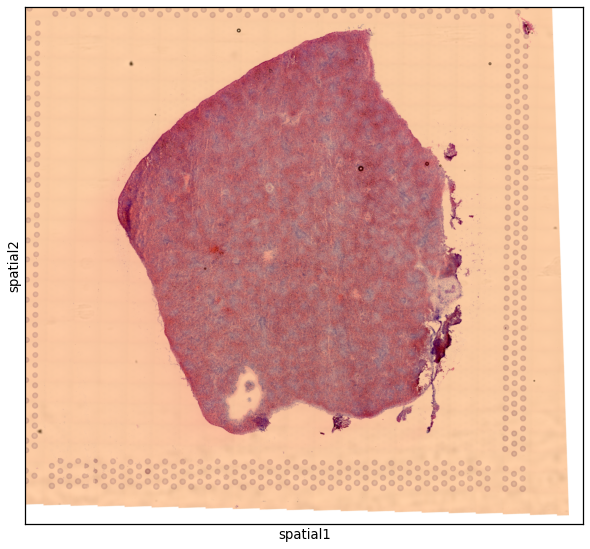

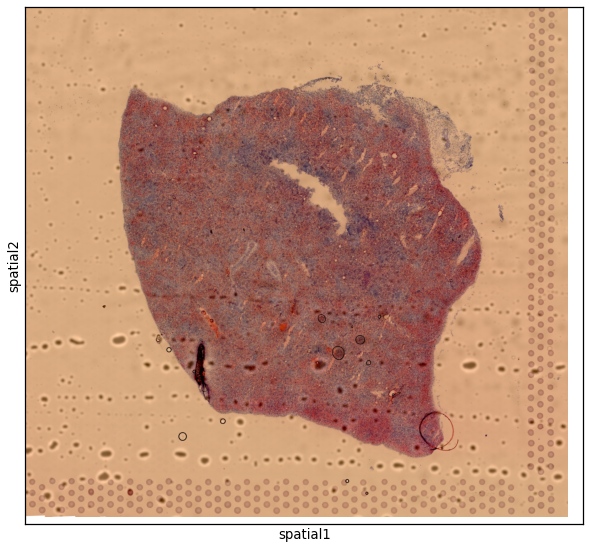

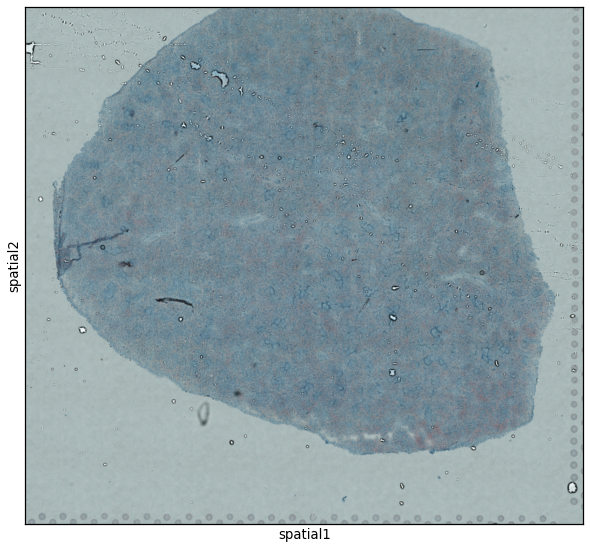

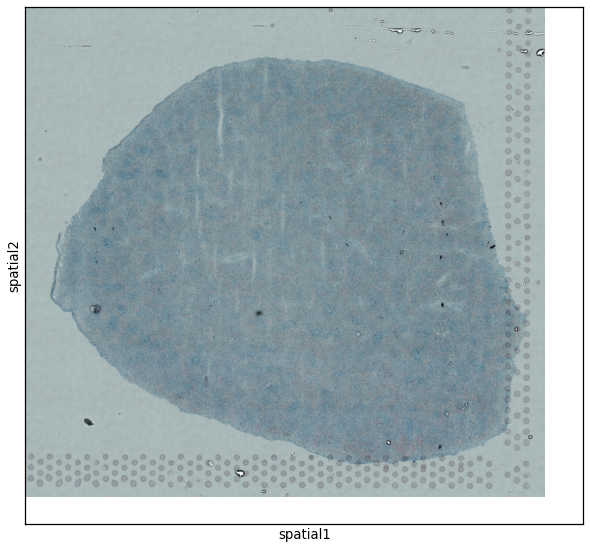

In [206]:
for l in lib_names:
    sc.pl.spatial(adata, library_id=l)

### Visualize spatial expression of a gene

In [207]:
## Set var names to gene names 
adata.var_names = adata.var['SYMBOL'].copy()

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:891: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


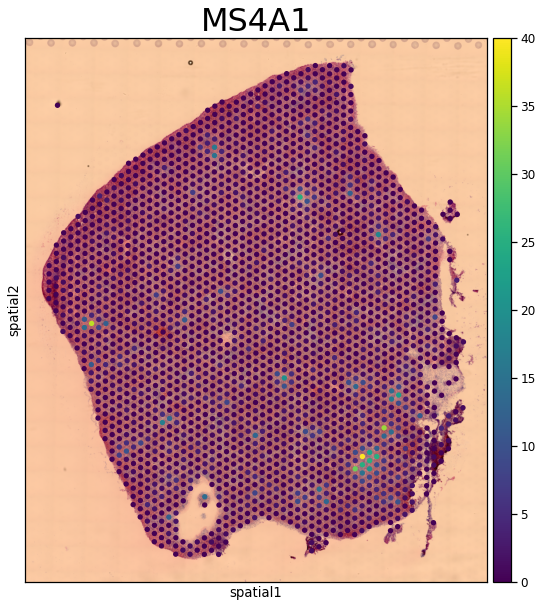

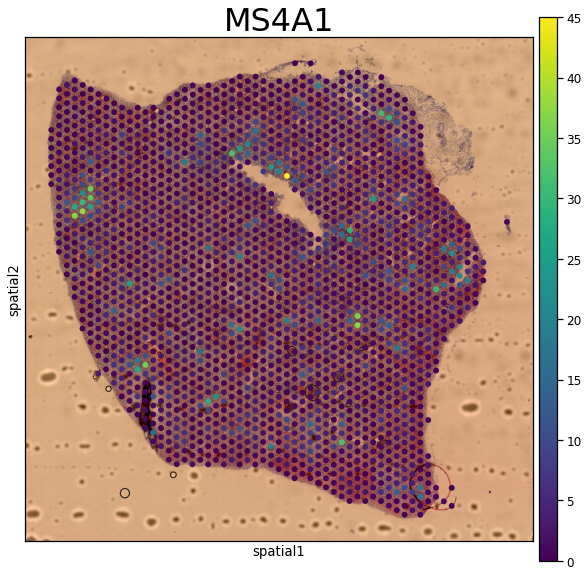

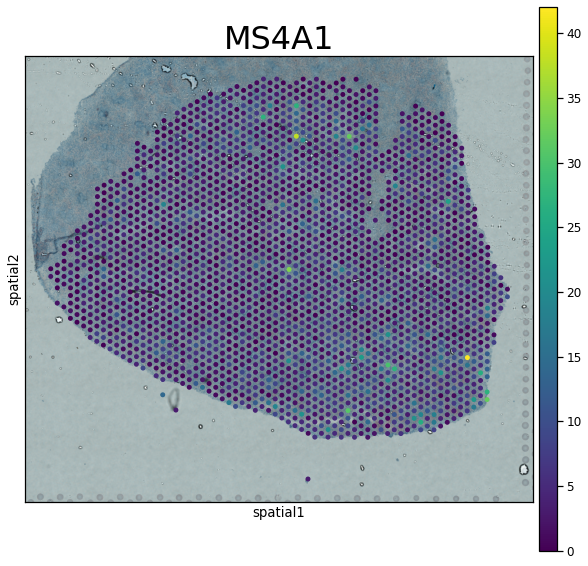

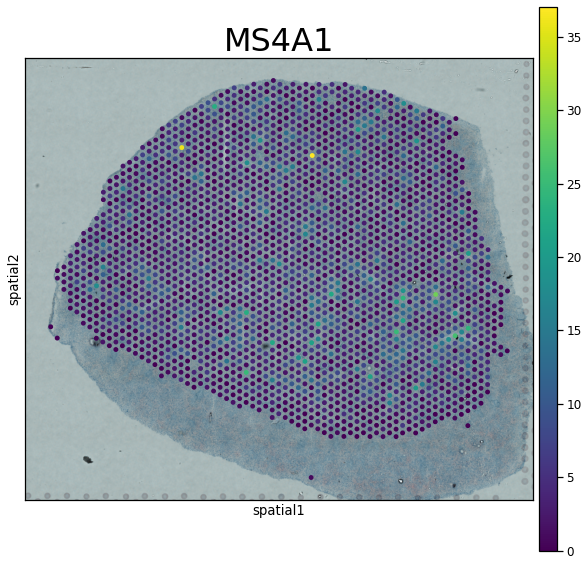

In [208]:
for l in lib_names:
    sc.pl.spatial(_select_lib_spots(adata, l), color='MS4A1', library_id=l)

### Visualize estimated spatial cell type abundances

The outputs from `cell2location` are stored in the anndata object. 
- `adata_vis.obsm['q05_cell_abundance_w_sf']` stores the matrix of cell type abundances for each spot

In [209]:
adata.obsm['q05_cell_abundance_w_sf']
# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata.obs[adata.uns['mod']['factor_names']] = adata.obsm['q05_cell_abundance_w_sf'].copy()
adata.obs[adata.uns['mod']['factor_names']]

ABT(ENTRY)        B1  \
spot_id                                                                    
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...    0.006632  0.008283   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...    0.073659  0.098395   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...    0.076408  0.101603   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...    0.053271  0.069762   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...    0.028853  0.023754   
...                                                        ...       ...   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...    0.168291  4.777830   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...    0.352381  5.572552   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...    0.092381  2.364912   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...    0.102407  3.151014   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...    0.022308  2.012998   

                                                       CD4+T     CD8+T  \
spot_id                                                                  
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...  0.018783  0.006516   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...  0.164788  0.070779   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...  0.208358  0.088837   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...  0.131587  0.048559   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...  0.041873  0.022761   
...                                                      ...       ...   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...  1.917655  1.240136   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...  3.359442  2.411113   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...  1.247711  0.924213   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...  1.310761  0.907309   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...  0.340475  0.194227   

                                                       CD8AA       CMP  \
spot_id                                                                  
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...  0.000127  0.000106   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...  0.002786  0.007277   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...  0.004418  0.017279   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...  0.001131  0.001511   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...  0.006210  0.018147   
...                                                      ...       ...   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...  0.241064  0.715111   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...  3.300742  1.036070   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...  0.157479  0.713066   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...  0.148672  0.983357   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...  0.059849  0.116973   

                                                    CYCLING_B  CYCLING_DC  \
spot_id                                                                     
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...   0.000832    0.000371   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...   0.023893    0.001983   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...   0.025639    0.024894   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...   0.011645    0.000592   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...   0.006046    0.031853   
...                                                       ...         ...   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...   0.728694    0.014944   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...   1.094938    0.250357   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...   0.410297    0.044573   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...   0.509666    0.023169   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...   0.312537    0.072821   

                                                    CYCLING_FIBROBLAST_I  \
spot_id                                                    

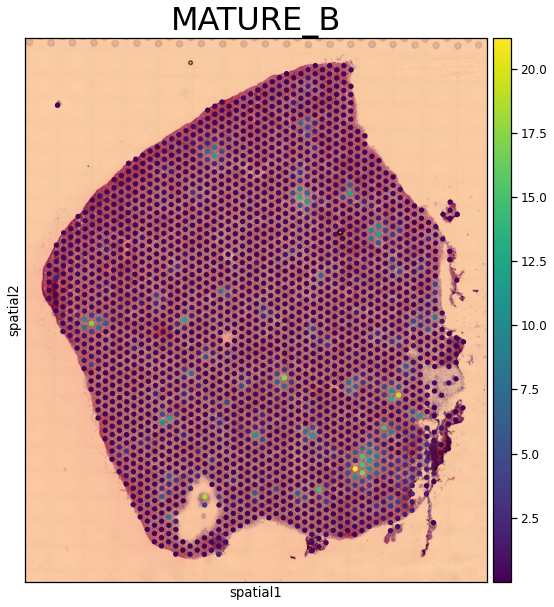

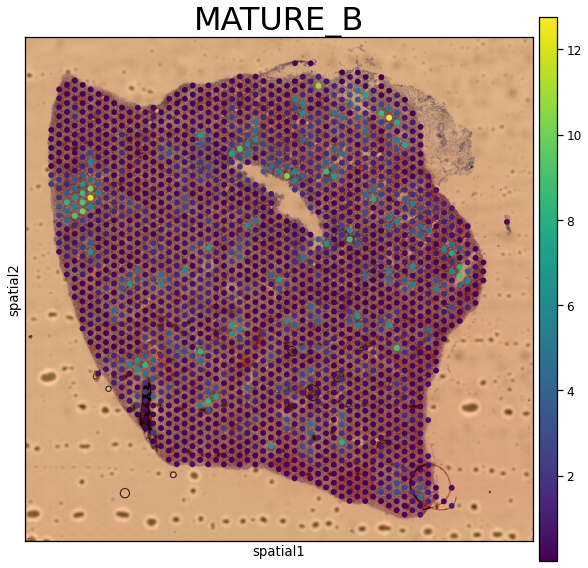

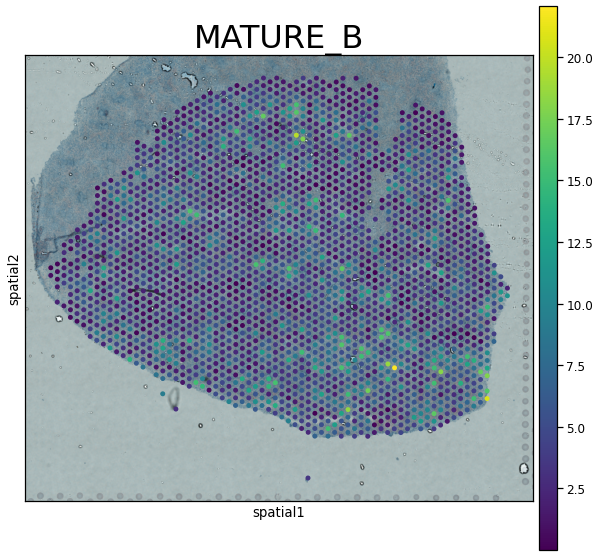

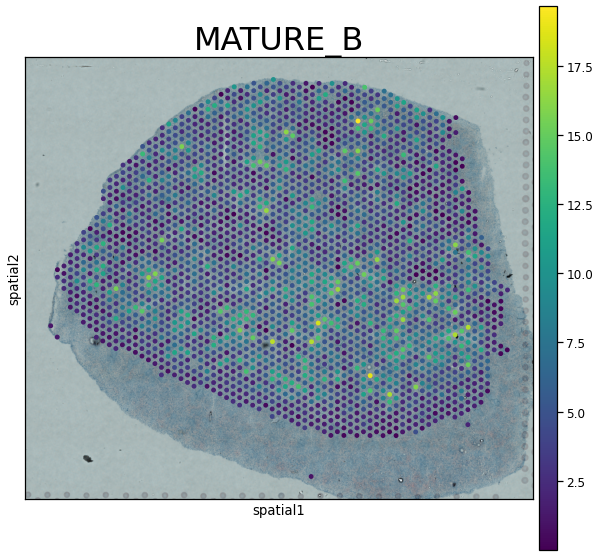

In [210]:
for l in lib_names:
    sc.pl.spatial(_select_lib_spots(adata, l), color='MATURE_B', library_id=l)

### Visualize tissue microenvironments

Values for NMF factors representing microenvironments of co-localized cell types are stored in `adata.obsm['NMF']`

In [211]:
adata.obsm['NMF']

fact_0     fact_1  \
spot_id                                                                    
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...   3.743784   5.105565   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...  11.300525  19.989722   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...  15.086372  18.511701   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...  15.315054  14.263639   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...   5.528565  11.501464   
...                                                       ...        ...   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...   5.246429   0.000000   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...   4.295638   0.000000   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...   0.000000   0.000000   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...   4.954188   1.948608   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...   0.000000   0.000000   

                                                      fact_2     fact_3  \
spot_id                                                                   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...  0.792576   4.144216   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...  1.760658  15.048368   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...  4.223145  18.299252   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...  0.639837  11.480830   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...  0.784121   8.228922   
...                                                      ...        ...   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...  2.460647   0.000000   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...  3.279760   1.031045   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...  3.980738   1.843647   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...  2.083177   0.769467   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...  0.493340   0.000000   

                                                       fact_4    fact_5  \
spot_id                                                                   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...   0.472124  2.253525   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...   9.052256  6.191600   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...   1.780509  5.223277   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...   2.607720  7.496557   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...  29.532118  2.200082   
...                                                       ...       ...   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...   0.000000  1.511924   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...   0.000000  2.559845   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...   2.551010  3.191858   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...   0.000000  5.244348   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...   0.000000  1.529754   

                                                       fact_6     fact_7  \
spot_id                                                                    
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...   1.106501   0.000000   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...   3.441738   0.000000   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...   1.814622   1.526795   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...   0.985474   0.000000   
spaceranger130_count_36654_WSSS_F_IMMsp9838710_...   0.000000   2.002135   
...                                                       ...        ...   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...   1.884441   3.586860   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...   6.089015   3.946331   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...  12.937803   1.853969   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...   5.895898   0.646237   
spaceranger130_count_WSSS_F_IMMsp10864182_GRCh3...   0.000000  10.356214   

                                                      fact_8     fact_9  
spot_id                                            

In [212]:
## Add factors to obs for visualization
adata.obs = pd.concat([adata.obs, adata.obsm["NMF"]], 1)

In [216]:
lib_names
l='spaceranger130_count_36811_WSSS_F_IMMsp9838715_GRCh38-2020-A'

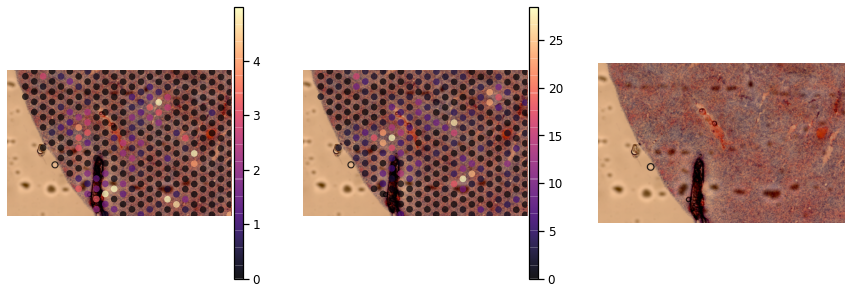

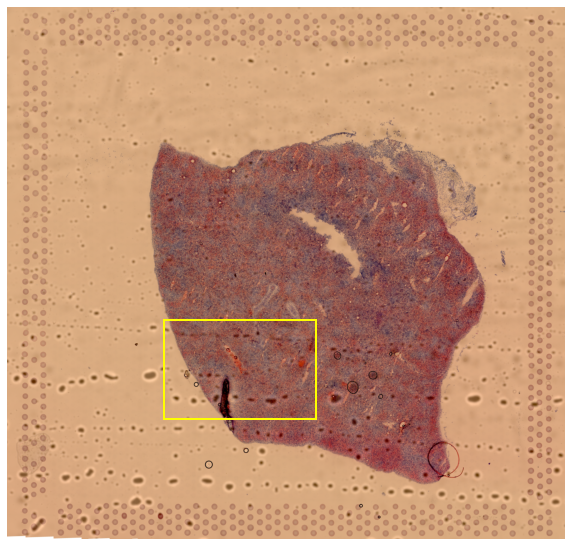

In [219]:
nrow=1
ncol=3
coords = [2300, 4535,4594,6045]

fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs = axs.reshape((nrow, ncol))

from itertools import chain
ind = list(chain(*[[(i, j) for i in range(nrow)] for j in range(ncol)]))
for i, c in enumerate(['fact_8', 'fact_9', None]):
    # c='fact_9'
    if c is not None:
        vmax = np.quantile(_select_lib_spots(adata, l).obs[c].values, 0.992)
        vmin=0
        spot_alpha=0.7
    else:
        vmax=None
        vmin=None
        spot_alpha=0
    sns.set_context("notebook", font_scale=1.1)
    plt.rcParams["figure.figsize"] = [10,10]
    plt.rcParams['axes.titlesize'] = 32
    sc.pl.spatial(_select_lib_spots(adata, l), color=c, library_id=l,ncols=1, size=1, 
                          vmin=vmin, vmax=vmax, crop_coord=coords, alpha=spot_alpha,
                          cmap="magma", frameon=False, title="", 
                          ax=axs[ind[i][0],ind[i][1]], show=False,
                          img_key='hires')
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/spatial_mapping_EDA/"
fig.savefig(figdir + 'spl_lymph_aggregates_zoom.pdf')

fig, ax = plt.subplots(1,1)
ax.imshow(adata.uns['spatial'][l]['images']['hires'])
ax.axis('off')
# write rectangle on plot (for extract)
sf = adata.uns['spatial'][l]['scalefactors']['tissue_hires_scalef']
rect = matplotlib.patches.Rectangle((coords[0]*sf,coords[2]*sf), 
                                    width=(coords[1]-coords[0])*sf, 
                                    height=(coords[3]-coords[2])*sf, 
                                    ec='yellow', lw=2, fill=False)
ax.add_patch(rect)
fig.savefig(figdir + 'spl_lymph_aggregates_zoom_inset.pdf')

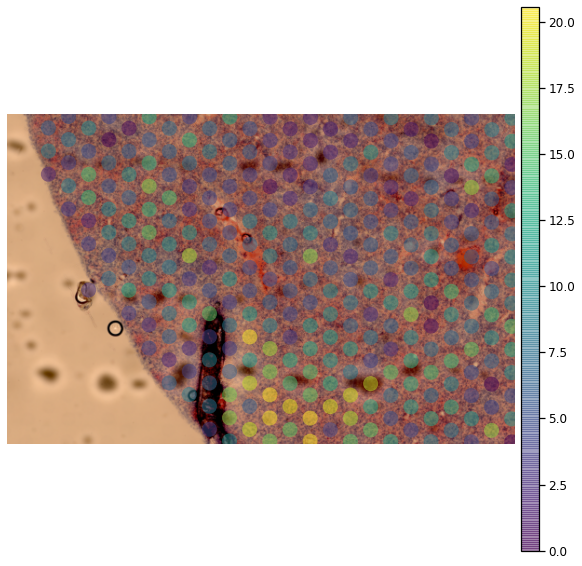

In [218]:
c='fact_3'
vmax = np.quantile(_select_lib_spots(adata, l).obs[c].values, 0.992)
sns.set_context("notebook", font_scale=1.1)
plt.rcParams["figure.figsize"] = [10,10]
plt.rcParams['axes.titlesize'] = 32
sc.pl.spatial(_select_lib_spots(adata, l), color=c, library_id=l,ncols=1, size=1, 
                      vmin=0, vmax=vmax,crop_coord=coords, alpha=0.5,
                      cmap="viridis", frameon=False, title="",
#                       ax=axs[ind[pos_ix][0],ind[pos_ix][1]], show=False,
                      img_key='hires')

_to be continued..._